In [1]:
# Import the necessary packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics

import matplotlib.transforms
import time

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import time
import lime
from lime import lime_tabular
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_predict
from sklearn.metrics import make_scorer

In [2]:
# Import the dataframes
loans = pd.read_csv('loan_table.csv')
borrowers = pd.read_csv('borrower_table.csv')

%time

Wall time: 0 ns


In [3]:
# Check the duplicates
a= loans.shape[0] - loans.loan_id.nunique()
b= borrowers.shape[0] - borrowers.loan_id.nunique()

print("There are {} loan_id duplicates in the loans dataset.".format(a))
print("There are {} loan_id duplicates in the borrowers dataset.".format(b))

%time

There are 0 loan_id duplicates in the loans dataset.
There are 0 loan_id duplicates in the borrowers dataset.
Wall time: 0 ns


In [4]:
# Checking if all loan_id-s are the same. Sort the tables first by loan_id in ascending order:

loans_asc = loans.sort_values(by=['loan_id'])
borrowers_asc = borrowers.sort_values(by=['loan_id'])

# Put the loan_id columns of both table into lists:
borrowers_loan_id = list(borrowers_asc['loan_id'])
loans_loan_id = list(loans_asc['loan_id'])

# Check if they are identical:

if borrowers_loan_id==loans_loan_id:
    print ("The lists are identical, meaning that the loan_id-s are the same in the tables.")
else:
    print("The lists are not identical,meaning that the loan_id-s are not the same in the tables.")
    
%time

The lists are identical, meaning that the loan_id-s are the same in the tables.
Wall time: 0 ns


### Merge the two dataframes

In [5]:

merged_loans= pd.merge(loans, borrowers, how='left', on='loan_id')
merged_loans.head()


,loan_id,loan_purpose,date,loan_granted,loan_repaid,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
0,19454,investment,15/03/2012,0,NaN,1,NaN,NaN,8600,0.79,1491,6285,1,45200,42,7
1,496811,investment,17/01/2012,0,NaN,1,NaN,NaN,5300,0.52,141,5793,0,0,42,5
2,929493,other,09/02/2012,0,NaN,1,NaN,NaN,0,NaN,660,3232,1,26500,60,4
3,580653,other,27/06/2012,1,1.0,0,1.0,0.0,5400,0.52,3345,2764,1,15800,58,4
4,172419,business,21/05/2012,1,0.0,1,NaN,NaN,2900,0.76,1050,3695,1,34800,31,4


In [6]:
merged_loans.dtypes

loan_id                                              int64
loan_purpose                                        object
date                                                object
loan_granted                                         int64
loan_repaid                                        float64
is_first_loan                                        int64
fully_repaid_previous_loans                        float64
currently_repaying_other_loans                     float64
total_credit_card_limit                              int64
avg_percentage_credit_card_limit_used_last_year    float64
saving_amount                                        int64
checking_amount                                      int64
is_employed                                          int64
yearly_salary                                        int64
age                                                  int64
dependent_number                                     int64
dtype: object

In [7]:
missing_value_merged_loans = pd.DataFrame(index = merged_loans.keys(), data =merged_loans.isnull().sum(), columns = ['Missing_Value_Count'])
missing_value_merged_loans['Missing_Value_Percentage'] = np.round(((merged_loans.isnull().mean())*100),2)
missing_value_merged_loans.sort_values('Missing_Value_Count',ascending= False)

,Missing_Value_Count,Missing_Value_Percentage
fully_repaid_previous_loans,54947,54.35
currently_repaying_other_loans,54947,54.35
loan_repaid,53446,52.86
avg_percentage_credit_card_limit_used_last_year,6972,6.90
loan_id,0,0.00
loan_purpose,0,0.00
date,0,0.00
loan_granted,0,0.00
is_first_loan,0,0.00
total_credit_card_limit,0,0.00


### Dealing with NaN values: 
* *loan_repaid*: where there was not any loan granted (loan_granted value is 0), there the loan_repaid value can be -1.
* *fully_repaid_previous loans*, *currently repaying_other_loans*: if it is first loan, same applies as above
* *avg_percentage_credit_card_limit_used_last_year*: the low proportion of NaN values does not cause any problem, I simply replace them with 0.

In [9]:
merged_loans['final_loan_repaid'] = np.where(merged_loans['loan_granted']==0, -1, merged_loans['loan_repaid'])
merged_loans['final_fully_repaid_previous_loans'] = np.where(merged_loans['is_first_loan']==1, -1, merged_loans['fully_repaid_previous_loans'])
merged_loans['final_currently_repaying_other_loans'] = np.where(merged_loans['is_first_loan']==1, -1, merged_loans['currently_repaying_other_loans'])

In [16]:
merged_loans['avg_percentage_credit_card_limit_used_last_year']=merged_loans['avg_percentage_credit_card_limit_used_last_year'].fillna(0)

In [19]:
merged_loans_copy=merged_loans.copy()

In [24]:
# Drop unneccesary columns:
merged_loans_copy = merged_loans_copy.drop(['loan_repaid', 'fully_repaid_previous_loans', 'currently_repaying_other_loans'], axis=1)

In [26]:
merged_loans_copy.isna().sum()

loan_id                                            0
loan_purpose                                       0
date                                               0
loan_granted                                       0
is_first_loan                                      0
total_credit_card_limit                            0
avg_percentage_credit_card_limit_used_last_year    0
saving_amount                                      0
checking_amount                                    0
is_employed                                        0
yearly_salary                                      0
age                                                0
dependent_number                                   0
final_loan_repaid                                  0
final_fully_repaid_previous_loans                  0
final_currently_repaying_other_loans               0
dtype: int64

In [28]:
loan_granted=merged_loans_copy[merged_loans_copy['loan_granted']==1]
loan_granted.head()

,loan_id,loan_purpose,date,loan_granted,is_first_loan,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number,final_loan_repaid,final_fully_repaid_previous_loans,final_currently_repaying_other_loans
3,580653,other,27/06/2012,1,0,5400,0.52,3345,2764,1,15800,58,4,1.0,1.0,0.0
4,172419,business,21/05/2012,1,1,2900,0.76,1050,3695,1,34800,31,4,0.0,-1.0,-1.0
6,780070,business,14/03/2012,1,0,7800,0.30,4206,4368,1,51100,51,2,1.0,1.0,0.0
7,303138,emergency_funds,31/08/2012,1,0,4300,1.02,886,1597,1,15000,59,2,0.0,0.0,1.0
8,91475,investment,25/05/2012,1,0,3900,0.65,1837,3795,1,12000,24,1,1.0,1.0,0.0


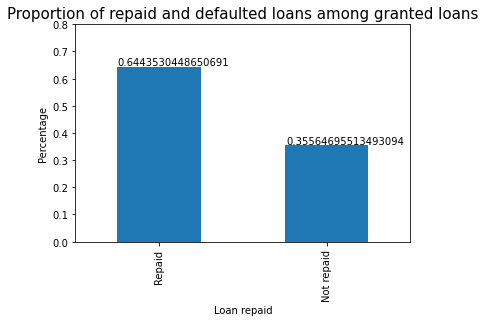

In [217]:
ax = loan_granted['loan_repaid'].value_counts(normalize=True).plot.bar()

plt.xlabel('Loan repaid')   # Set the x-axis label
plt.ylabel('Percentage')  # Set the y-axis label
plt.title('Proportion of repaid and defaulted loans among granted loans', fontsize=15)
plt.xticks((0,1), ["Repaid", "Not repaid"])
ax.set_ylim(0,0.8)

for p in ax.patches:
    
    ax.annotate(str(p.get_height()), (p.get_x() * 1.01, p.get_height() * 1.01))

# Random Forest Model

In [29]:
# Copy dataset
loans_tr=merged_loans_copy.copy()

In [30]:
# Filter for only granted loans
granted_loans = loans_tr.loc[(loans_tr['loan_granted'] == 1)]

In [31]:
print(f'number of granted loans: {granted_loans.shape[0]} ')

number of granted loans: 47654 


In [55]:
rf = RandomForestClassifier(random_state = 42)

In [186]:
class LoanClassifier:
    '''
    Use RandomForestClassifier to classified a loan as fully-paid or default.
    '''
    
    def __init__(self, model_name, param, features):
        '''
        Initialize and create model.
        
        Parameters:
        - model_name: name of the model
        - param: a dictionary of parameters for grid search
        - features: a list of features to be used in the model
        '''
        
        self.model_name = model_name
        self.model = GridSearchCV(estimator=RandomForestClassifier(random_state=42), 
                                  param_grid=param, cv=3, n_jobs=-1, verbose=2)
        self.features = features
        self.feature_imp = self.metrics = None
        self.y_predict = self.predict_proba = None
        self.explainer = None
        self.predict_fn_rf = lambda x: self.model.predict_proba(x).astype(float)
    
    def train_n_evaluate(self, X_train, Y_train, X_test, Y_test):
        '''
        Train and evaluate model.
        
        parameters:
        - X_train: training set
        - y_train: class label for training set
        - X_test: test set
        - y_test: class label for test set
        '''
        
        start_time = time.time()
        self.model.fit(X_train, Y_train)                                # fit the model
        stop_time = time.time()
        self.y_predict = self.model.predict(X_test)                     # predictions for test set
        self.predict_proba = self.model.predict_proba(X_test)           # prediction' probability
        c_matrix = metrics.confusion_matrix(Y_test, self.y_predict)     # confusion matrix
        
        # build a dictionary of performance metrics
        metrics_dict = {'model_name': self.model_name,
                        'true_neg': c_matrix[0][0],
                        'true_pos': c_matrix[1][1],
                        'false_neg': c_matrix[1][0],
                        'false_pos': c_matrix[0][1],
                        'accuracy': metrics.accuracy_score(Y_test, self.y_predict),
                        'precision': metrics.precision_score(Y_test, self.y_predict),
                        'recall': metrics.recall_score(Y_test, self.y_predict),
                        'f1_score': metrics.f1_score(Y_test, self.y_predict),
                        'training_time': round(stop_time - start_time)}
        self.metrics = pd.DataFrame(metrics_dict, index=[0])
        
        # sort feature importance in descending order
        self.feature_imp = pd.Series(self.model.best_estimator_.feature_importances_, 
                                index=self.features).sort_values(ascending=False)
    
        # create explainer to help explain the prediction
        self.explainer = lime_tabular.LimeTabularExplainer(X_train.values, feature_names = X_train.columns,
                                              class_names=['Loan Repaid', 'Default'], kernel_width=5)
    
    def explain_prediction(self, row, num_features=5):
        '''
        Show horizontal bar plot of prediction's probability along with the score for the top 5 features.
        
        Parameters:
        - row: row's number in the test set
        - num_features: the number of top features to show along with its' score
        '''
        
        # show prediction and explanation, show the top 5 features
        exp = self.explainer.explain_instance(row, self.predict_fn_rf, num_features=num_features)
        exp.show_in_notebook(show_all=False)
        return exp
    
    def plot_feature_importance(self, figsize=(6, 6)):
        '''
        Create a bar plot of feature importance
        
        Parameter:
        - figsize: size of the figure
        '''
        
        fig, ax = plt.subplots(figsize=figsize)
        
        # create a bar plot of feature importance
        sns.barplot(x=self.feature_imp, y=self.feature_imp.index)

        # add labels to graph
        plt.xlabel('Score')
        plt.ylabel('Features')
        plt.title('Feature Importance')
        plt.show()

In [10]:
# Split data to train and test data:
cols_of_interest = ['loan_granted',
 'is_first_loan', 'total_credit_card_limit', 'saving_amount',
 'checking_amount', 'is_employed', 'yearly_salary', 'age', 'dependent_number',
 'loan_repaid', 'fully_repaid_previous_loans',
 'currently_repaying_other_loans', 'avg_percentage_credit_card_limit']

train_original=granted_loans[cols_of_interest]
train_dummy = pd.get_dummies(train_original)

In [178]:
X = train_dummy.drop(['loan_repaid'], axis=1)

In [179]:
Y = train_dummy.loan_repaid

In [180]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3, stratify=Y)

In [181]:
X2 = pd.concat([X_train, X_test])

In [182]:
X2.isna().sum()

loan_granted                        0
is_first_loan                       0
total_credit_card_limit             0
saving_amount                       0
checking_amount                     0
is_employed                         0
yearly_salary                       0
age                                 0
dependent_number                    0
fully_repaid_previous_loans         0
currently_repaying_other_loans      0
avg_percentage_credit_card_limit    0
dtype: int64

In [165]:
# parameters for base model and reduced features model
param = {'bootstrap': [True], 'n_estimators': [100]}

C:\Users\lkond\Dropbox\Programok\Python\Anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


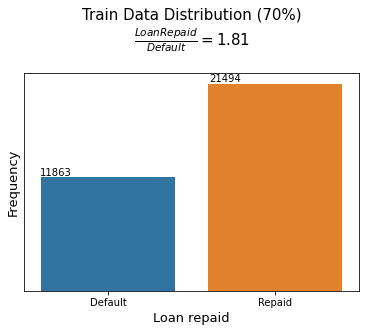

In [221]:
proportion = round(len(Y_train[Y_train==1]) / len(Y_train[Y_train==0]),2)

fig, ax = plt.subplots()
sns.countplot(Y_train, ax=ax)


plt.yticks([])
plt.ylabel('Frequency', size=13)
plt.xlabel('Loan repaid', size=13)
plt.title('Train Data Distribution (70%)\n' + r'$\frac{LoanRepaid}{Default}=' + str(proportion) + '$\n', size=15)
plt.xticks((0,1), ["Default", "Repaid"])

for p in ax.patches:

    ax.annotate(str(p.get_height()), (p.get_x() * 1.01, p.get_height() * 1.01))

plt.show()

## First Random Forest Model: Base model

In [187]:
base_model = LoanClassifier('base_model', param, list(X_train.columns))
base_model.train_n_evaluate(X_train, Y_train, X_test, Y_test)
base_model.metrics

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.4s finished


,model_name,true_neg,true_pos,false_neg,false_pos,accuracy,precision,recall,f1_score,training_time
0,base_model,4615,8545,667,470,0.920473,0.947865,0.927594,0.93762,13


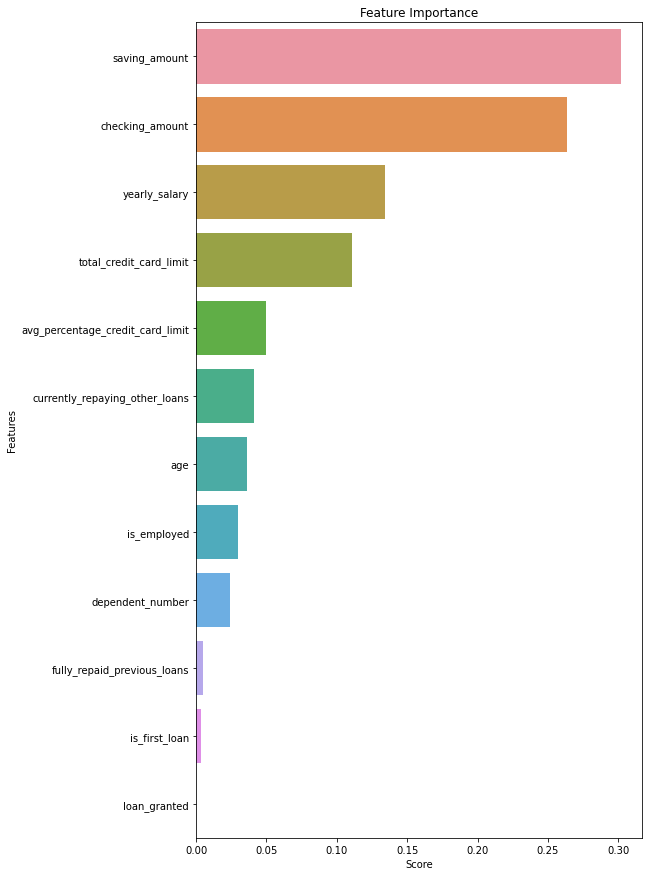

In [188]:
base_model.plot_feature_importance((8, 15))

## Second Random Forest Model: Model 1

In [189]:
# select features with important score > 0.04
features_m1 = list(base_model.feature_imp[base_model.feature_imp > 0.04].index)

model1 = LoanClassifier('feature_reduction', param, features_m1)
model1.train_n_evaluate(X_train[features_m1], Y_train, X_test[features_m1], Y_test)
model1.metrics

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.8s finished


,model_name,true_neg,true_pos,false_neg,false_pos,accuracy,precision,recall,f1_score,training_time
0,feature_reduction,4614,8515,697,471,0.918305,0.947585,0.924338,0.935817,10


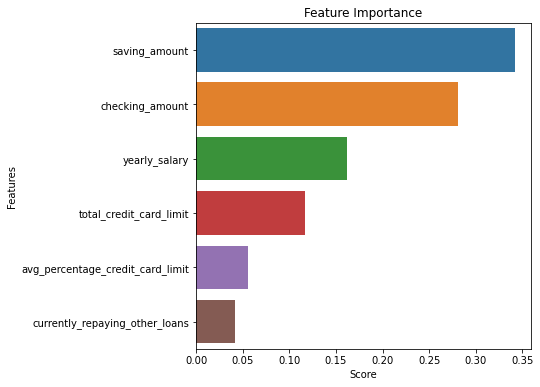

In [190]:

model1.plot_feature_importance()

### Model 2 with grid search

In [191]:
param_grid = {'bootstrap': [True],
              'max_depth': [10, 20, 30],
              'max_features': ['sqrt'],
              'min_samples_leaf': [5, 6, 7],
              'min_samples_split': [6, 8, 10],
              'n_estimators': [80, 100, 120]}

model2 = LoanClassifier('grid_search', param_grid, features_m1)
model2.train_n_evaluate(X_train[features_m1], Y_train, X_test[features_m1], Y_test)
model2.metrics

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:  4.1min finished


,model_name,true_neg,true_pos,false_neg,false_pos,accuracy,precision,recall,f1_score,training_time
0,grid_search,4617,8528,684,468,0.919424,0.947977,0.925749,0.936731,252


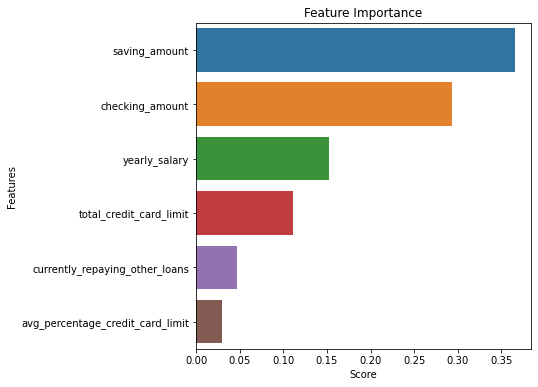

In [109]:
model2.plot_feature_importance()

### Model Comparison

#### ROC Curve

ROC curve shows the trade-off between the true positive rate (TPR) and the false positive rate (FPR). Any increase in TPR occurs at the cost of an increase in FPR. The area under the ROC curve is a measure of the accuracy of the model.

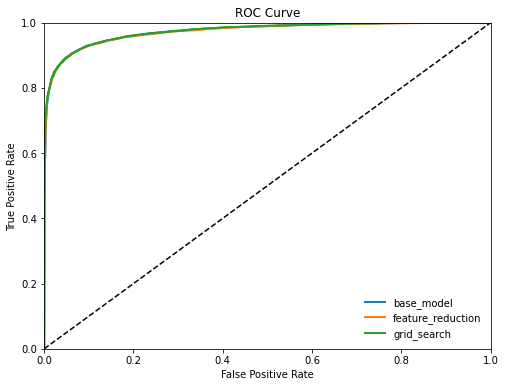

In [192]:
# plot roc curve for all models
fig, ax = plt.subplots(figsize=(8, 6))
labels = ['base_model', 'feature_reduction', 'grid_search']

# iterate through all the models and plot roc curve for each model
for i, model in enumerate([base_model, model1, model2]):
    fpr, tpr, _ = metrics.roc_curve(Y_test, model.predict_proba[:,1])
    plt.plot(fpr, tpr, linewidth=2, label=labels[i])

plt.legend(loc='best', frameon=False)
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

The ROC curves appear to be overlapped, and it looks like that base model and grid search (model2) performs slightly better than model 1 (feature_reduction). 

#### Performance metrics

I compare the three models based on the following metrics:

* Accuracy = (True Positives + True Negatives) / (Positive + Negative)
* Precision = True Positive / (True Positive + False Positive)
* Sensitivity (Recall) = True Positive / Positive
* F1 score (harmonic mean of precision and sensitivity) = (2*precision*sensitivity) / (precision+sensitivity)

In [193]:
# a data frame that contains performance metrics for all model
metrics_all = pd.concat([base_model.metrics, model1.metrics, model2.metrics])

metrics_all

,model_name,true_neg,true_pos,false_neg,false_pos,accuracy,precision,recall,f1_score,training_time
0,base_model,4615,8545,667,470,0.920473,0.947865,0.927594,0.937620,13
0,feature_reduction,4614,8515,697,471,0.918305,0.947585,0.924338,0.935817,10
0,grid_search,4617,8528,684,468,0.919424,0.947977,0.925749,0.936731,252


* The accuracy score is almost the same for the three models
* The base model has the highest accuracy, TP and recall, lowest false negative.
* Model 2 is almost as much good as the base model, only the TP cases are slightly less. However, it took the longest time to train.

After evaluating the models, I chose to use the base model as a loan classifier. However, since it uses all features in making the prediction, it is more likely to overfit the model. 

### Model Prediction

In [114]:
test_fp = X_test.iloc[0]                                                      # obs being predicted as fully-paid
test_df = X_test.loc[Y_test[base_model.predict_proba[:, 1] > 0.8].index[0]]   # obs being predicted as default

In [258]:
# Making prediction with selected model on test dataset (base model)
best_model = base_model
rf_predictions = pd.concat([X_test[['loan_granted']]])
rf_predictions['actual_label'] = Y_test
rf_predictions['actual_label'] = rf_predictions['actual_label'].apply(lambda x: 'loan repaid' if x == 1 else 'default')
rf_predictions['predict_label'] = best_model.y_predict
rf_predictions['predict_label'] = rf_predictions['predict_label'].apply(lambda x: 'loan repaid' if x == 1 else 'default')
rf_predictions['prob_default'] = best_model.predict_proba[:,0]      # probability of default
rf_predictions['prob_fully_paid'] = best_model.predict_proba[:, 1] # probability of fully-paid

rf_predictions.head(8)

,loan_granted,actual_label,predict_label,prob_default,prob_fully_paid
68722,1,loan repaid,loan repaid,0.00,1.00
12282,1,loan repaid,loan repaid,0.00,1.00
51094,1,loan repaid,loan repaid,0.03,0.97
58685,1,loan repaid,loan repaid,0.23,0.77
49125,1,default,loan repaid,0.41,0.59
71173,1,loan repaid,loan repaid,0.00,1.00
82027,1,loan repaid,default,0.89,0.11
4263,1,default,default,0.78,0.22


In [208]:
good = rf_predictions.loc[rf_predictions['actual_label'] != rf_predictions['predict_label']]
good.head()

,loan_granted,actual_label,predict_label,prob_fully_paid,prob_default
49125,1,default,loan repaid,0.41,0.59
82027,1,loan repaid,default,0.89,0.11
18179,1,default,loan repaid,0.45,0.55
2271,1,loan repaid,default,0.97,0.03
20009,1,loan repaid,default,0.77,0.23


In [209]:
good.shape

(1137, 5)

In [218]:
wrong = len(good)/len(rf_predictions)
right = 1-wrong

C:\Users\lkond\Dropbox\Programok\Python\Anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'Distribution of chosen Model Predictions')

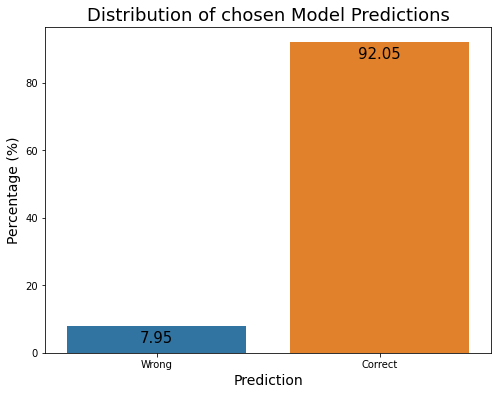

In [255]:
objects = ('Wrong', 'Correct')
y_pos = np.arange(len(objects))
values = [wrong*100, right*100]


plt.figure(figsize=(8, 6))
splot=sns.barplot(y_pos, values)


for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, -12), 
                   textcoords = 'offset points')
plt.xticks(y_pos, objects)
plt.xlabel("Prediction", size=14)
plt.ylabel("Percentage (%)", size=14)
plt.title('Distribution of chosen Model Predictions', size = 18)

## Logistic Regression

In [12]:
loans_lr=merged_loans_copy.copy()

In [15]:
granted_loans_lr = loans_lr.loc[(loans_lr['loan_granted'] == 1)]

In [16]:
train_original_lr=granted_loans_lr[cols_of_interest]
train_dummy_lr = pd.get_dummies(train_original_lr)

In [17]:
X = train_dummy.drop(['loan_repaid'], axis=1)

In [27]:
Y = train_dummy.loan_repaid

In [33]:
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.30,random_state=42)

In [47]:
model = LogisticRegression()
model.fit(X_train, y_train)
LogisticRegression()

C:\Users\lkond\Dropbox\Programok\Python\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [48]:
pred_cv = model.predict(X_test)
accuracy_score(y_test,pred_cv)

0.8296146044624746

In [49]:
pred_test = model.predict(X)

In [51]:
from sklearn.metrics import classification_report

In [52]:
print(classification_report(Y,pred_test))

              precision    recall  f1-score   support

         0.0       0.79      0.71      0.75     16948
         1.0       0.85      0.90      0.87     30706

    accuracy                           0.83     47654
   macro avg       0.82      0.80      0.81     47654
weighted avg       0.83      0.83      0.83     47654



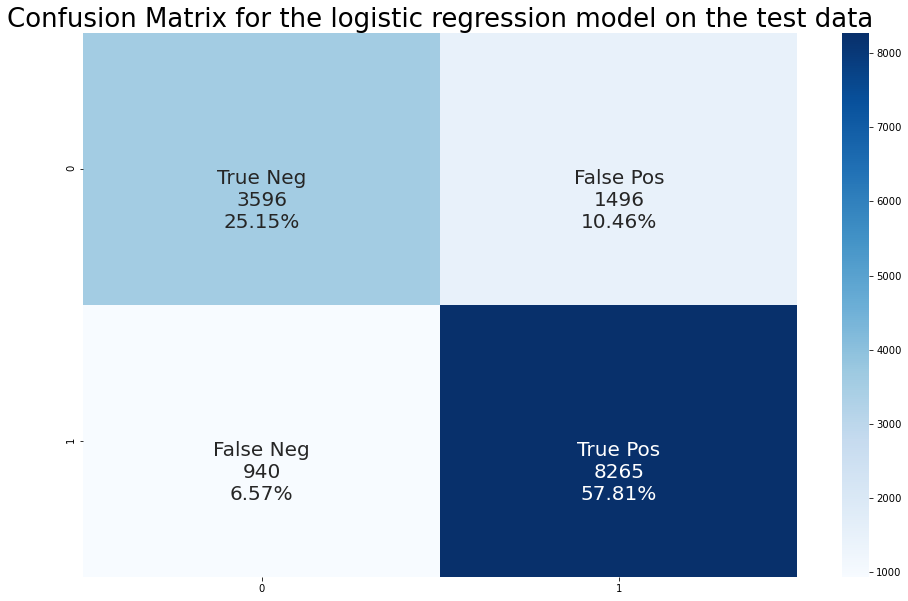

In [59]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     confusion_matrix.flatten()/np.sum(confusion_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize = (16,10))
akws = {"ha": 'center',"va": 'top', "size":20}

ax = sns.heatmap(pd.DataFrame(confusion_matrix), annot=labels, fmt='', cmap='Blues', annot_kws=akws )


for t in ax.texts:
    trans = t.get_transform()
    offs = matplotlib.transforms.ScaledTranslation(-0, 0,
                    matplotlib.transforms.IdentityTransform())
    t.set_transform( offs + trans )
plt.title('Confusion Matrix for the logistic regression model on the test data', size=26)
    
plt.show()